In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import patches
from scipy.spatial import ConvexHull
import pickle
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.model_selection import cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,precision_score,f1_score,recall_score
plt.style.use('seaborn')
from IPython.display import HTML
def pretty_print_df(value_counts_):
  "Quick function to display value counts more nicely"
  display(HTML(pd.DataFrame(value_counts_).to_html()))
from sklearn.compose import ColumnTransformer




<ipython-input-1-e2dcb2369dc6>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
results = pd.read_csv(r'/content/drive/MyDrive/F1data/results.csv')
races = pd.read_csv(r'/content/drive/MyDrive/F1data/races.csv')
quali = pd.read_csv(r'/content/drive/MyDrive/F1data/qualifying.csv')
drivers = pd.read_csv(r'/content/drive/MyDrive/F1data/driver_standings.csv')
constructors = pd.read_csv(r'/content/drive/MyDrive/F1data/constructor_standings.csv')
circuit = pd.read_csv(r'/content/drive/MyDrive/F1data/circuits.csv')
weather = pd.read_csv(r'/content/drive/MyDrive/F1data/weather.csv')

In [ ]:
#merging dataframe
df1 = pd.merge(races, weather, how='inner',
               on=['season', 'round', 'circuit_id']).drop(['lat', 'long','country','weather'],
                                                          axis = 1)
df2 = pd.merge(df1, results, how='inner',
               on=['season', 'round', 'circuit_id']).drop(['url','points', 'status', 'time'],
                                                                 axis = 1)
df3 = pd.merge(df2, drivers, how='left',
               on=['season', 'round', 'driver'])
df4 = pd.merge(df3, constructors, how='left',
               on=['season', 'round', 'constructor']) #from 1958

df5= pd.merge(df4, circuit, how ='inner',
              on=['circuit_id'])

final_df = pd.merge(df5, quali, how='inner',
                    on=['season', 'round', 'grid']).drop(['driver_name'],
                                                         axis = 1) #from 2018

final_df


,season,round,circuit_id,date,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,...,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,type,direction,country,length,constructor_y,qualifying_time
0,2018,1,albert_park,2018-03-25,1,0,0,0,0,vettel,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,Ferrari,1:21.838
1,2018,1,albert_park,2018-03-25,1,0,0,0,0,hamilton,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,Mercedes,1:21.164
2,2018,1,albert_park,2018-03-25,1,0,0,0,0,raikkonen,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,Ferrari,1:21.828
3,2018,1,albert_park,2018-03-25,1,0,0,0,0,ricciardo,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,Red Bull Racing TAG Heuer,1:22.152
4,2018,1,albert_park,2018-03-25,1,0,0,0,0,alonso,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,McLaren Renault,1:23.692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,2022,5,miami,2022-05-08,0,0,0,0,1,mick_schumacher,...,19.0,15.0,0.0,8.0,Street circuit,Anti-clockwise,United States,5.412,Haas Ferrari,1:30.423
1934,2022,5,miami,2022-05-08,0,0,0,0,1,kevin_magnussen,...,10.0,15.0,0.0,8.0,Street circuit,Anti-clockwise,United States,5.412,Haas Ferrari,1:30.975
1935,2022,5,miami,2022-05-08,0,0,0,0,1,gasly,...,13.0,16.0,0.0,7.0,Street circuit,Anti-clockwise,United States,5.412,AlphaTauri RBPT,1:29.690
1936,2022,5,miami,2022-05-08,0,0,0,0,1,norris,...,6.0,46.0,0.0,4.0,Street circuit,Anti-clockwise,United States,5.412,McLaren Mercedes,1:29.750


In [ ]:
#Inspection of Dataset
print(final_df.shape)
print(final_df.columns)
print(final_df.dtypes)
final_df.head(10)

(1938, 27)
Index(['season', 'round', 'circuit_id', 'date', 'weather_warm', 'weather_cold',
       'weather_dry', 'weather_wet', 'weather_cloudy', 'driver',
       'date_of_birth', 'nationality', 'constructor_x', 'grid', 'podium',
       'driver_points', 'driver_wins', 'driver_standings_pos',
       'constructor_points', 'constructor_wins', 'constructor_standings_pos',
       'type', 'direction', 'country', 'length', 'constructor_y',
       'qualifying_time'],
      dtype='object')
season                         int64
round                          int64
circuit_id                    object
date                          object
weather_warm                   int64
weather_cold                   int64
weather_dry                    int64
weather_wet                    int64
weather_cloudy                 int64
driver                        object
date_of_birth                 object
nationality                   object
constructor_x                 object
grid                           in

,season,round,circuit_id,date,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,...,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,type,direction,country,length,constructor_y,qualifying_time
0,2018,1,albert_park,2018-03-25,1,0,0,0,0,vettel,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,Ferrari,1:21.838
1,2018,1,albert_park,2018-03-25,1,0,0,0,0,hamilton,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,Mercedes,1:21.164
2,2018,1,albert_park,2018-03-25,1,0,0,0,0,raikkonen,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,Ferrari,1:21.828
3,2018,1,albert_park,2018-03-25,1,0,0,0,0,ricciardo,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,Red Bull Racing TAG Heuer,1:22.152
4,2018,1,albert_park,2018-03-25,1,0,0,0,0,alonso,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,McLaren Renault,1:23.692
5,2018,1,albert_park,2018-03-25,1,0,0,0,0,max_verstappen,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,Red Bull Racing TAG Heuer,1:21.879
6,2018,1,albert_park,2018-03-25,1,0,0,0,0,hulkenberg,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,Renault,1:23.532
7,2018,1,albert_park,2018-03-25,1,0,0,0,0,bottas,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,Mercedes,NaN
8,2018,1,albert_park,2018-03-25,1,0,0,0,0,vandoorne,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,McLaren Renault,1:23.853
9,2018,1,albert_park,2018-03-25,1,0,0,0,0,sainz,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,Australia,5.278,Renault,1:23.577


In [ ]:
final_df.drop(['constructor_y','country'], axis = 1, inplace = True)

In [ ]:
from dateutil.relativedelta import *
final_df['date'] = pd.to_datetime(final_df.date)
final_df['date_of_birth'] = pd.to_datetime(final_df.date_of_birth)
final_df['driver_age'] = final_df.apply(lambda x:
                                        relativedelta(x['date'], x['date_of_birth']).years, axis=1)
final_df.drop(['date', 'date_of_birth'], axis = 1, inplace = True)
final_df


,season,round,circuit_id,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,nationality,...,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,type,direction,length,qualifying_time,driver_age
0,2018,1,albert_park,1,0,0,0,0,vettel,German,...,0.0,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,1:21.838,30
1,2018,1,albert_park,1,0,0,0,0,hamilton,British,...,0.0,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,1:21.164,33
2,2018,1,albert_park,1,0,0,0,0,raikkonen,Finnish,...,0.0,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,1:21.828,38
3,2018,1,albert_park,1,0,0,0,0,ricciardo,Australian,...,0.0,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,1:22.152,28
4,2018,1,albert_park,1,0,0,0,0,alonso,Spanish,...,0.0,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,1:23.692,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,2022,5,miami,0,0,0,0,1,mick_schumacher,German,...,0.0,19.0,15.0,0.0,8.0,Street circuit,Anti-clockwise,5.412,1:30.423,23
1934,2022,5,miami,0,0,0,0,1,kevin_magnussen,Danish,...,0.0,10.0,15.0,0.0,8.0,Street circuit,Anti-clockwise,5.412,1:30.975,29
1935,2022,5,miami,0,0,0,0,1,gasly,French,...,0.0,13.0,16.0,0.0,7.0,Street circuit,Anti-clockwise,5.412,1:29.690,26
1936,2022,5,miami,0,0,0,0,1,norris,British,...,0.0,6.0,46.0,0.0,4.0,Street circuit,Anti-clockwise,5.412,1:29.750,22


In [ ]:
final_df['qualifying_time'] = final_df.qualifying_time.map(lambda x: 0 if str(x) == '00.000'
                                                         else (float(str(x).split(':')[1]) + (60 * float(str(x).split(':')[0])))
                                                         if ':' in str(x) else 0)
final_df = final_df[final_df['qualifying_time'] != 0]
final_df.sort_values(['season', 'round', 'grid'], inplace=True)
final_df['qualifying_time_diff'] = final_df.groupby(['season', 'round']).qualifying_time.diff()
final_df['qualifying_time'] = final_df.groupby(['season', 'round']).qualifying_time_diff.cumsum().fillna(0)
final_df.drop('qualifying_time_diff', axis=1, inplace=True)


<ipython-input-7-10b278d3a268>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.sort_values(['season', 'round', 'grid'], inplace=True)
<ipython-input-7-10b278d3a268>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['qualifying_time_diff'] = final_df.groupby(['season', 'round']).qualifying_time.diff()
<ipython-input-7-10b278d3a268>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [ ]:
final_df['cost_cap'] = final_df['season'] >= 2021
#final_df['Winner'] = final_df['podium'] == 1


<ipython-input-8-fe1c09a5a0e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['cost_cap'] = final_df['season'] >= 2021


In [ ]:
final_df

,season,round,circuit_id,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,nationality,...,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,type,direction,length,qualifying_time,driver_age,cost_cap
1,2018,1,albert_park,1,0,0,0,0,hamilton,British,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,0.000,33,False
2,2018,1,albert_park,1,0,0,0,0,raikkonen,Finnish,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,0.664,38,False
0,2018,1,albert_park,1,0,0,0,0,vettel,German,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,0.674,30,False
5,2018,1,albert_park,1,0,0,0,0,max_verstappen,Dutch,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,0.715,20,False
16,2018,1,albert_park,1,0,0,0,0,kevin_magnussen,Danish,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,2.023,25,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,2022,22,yas_marina,1,0,0,0,0,kevin_magnussen,Danish,...,13.0,37.0,0.0,8.0,Race circuit,Anti-clockwise,5.281,2.010,30,True
1640,2022,22,yas_marina,1,0,0,0,0,gasly,French,...,14.0,35.0,0.0,9.0,Race circuit,Anti-clockwise,5.281,2.035,26,True
1641,2022,22,yas_marina,1,0,0,0,0,bottas,Finnish,...,10.0,55.0,0.0,6.0,Race circuit,Anti-clockwise,5.281,2.068,33,True
1639,2022,22,yas_marina,1,0,0,0,0,albon,Thai,...,19.0,8.0,0.0,10.0,Race circuit,Anti-clockwise,5.281,2.204,26,True


In [ ]:
final_df['type'].value_counts()

Race circuit      1439
Street circuit     302
Name: type, dtype: int64

In [ ]:
finalA= final_df.copy()
finalA

,season,round,circuit_id,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,nationality,...,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,type,direction,length,qualifying_time,driver_age,cost_cap
1,2018,1,albert_park,1,0,0,0,0,hamilton,British,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,0.000,33,False
2,2018,1,albert_park,1,0,0,0,0,raikkonen,Finnish,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,0.664,38,False
0,2018,1,albert_park,1,0,0,0,0,vettel,German,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,0.674,30,False
5,2018,1,albert_park,1,0,0,0,0,max_verstappen,Dutch,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,0.715,20,False
16,2018,1,albert_park,1,0,0,0,0,kevin_magnussen,Danish,...,0.0,0.0,0.0,0.0,Street circuit,Clockwise,5.278,2.023,25,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,2022,22,yas_marina,1,0,0,0,0,kevin_magnussen,Danish,...,13.0,37.0,0.0,8.0,Race circuit,Anti-clockwise,5.281,2.010,30,True
1640,2022,22,yas_marina,1,0,0,0,0,gasly,French,...,14.0,35.0,0.0,9.0,Race circuit,Anti-clockwise,5.281,2.035,26,True
1641,2022,22,yas_marina,1,0,0,0,0,bottas,Finnish,...,10.0,55.0,0.0,6.0,Race circuit,Anti-clockwise,5.281,2.068,33,True
1639,2022,22,yas_marina,1,0,0,0,0,albon,Thai,...,19.0,8.0,0.0,10.0,Race circuit,Anti-clockwise,5.281,2.204,26,True


In [ ]:
finalA.isna().sum()

season                       0
round                        0
circuit_id                   0
weather_warm                 0
weather_cold                 0
weather_dry                  0
weather_wet                  0
weather_cloudy               0
driver                       0
nationality                  0
constructor_x                0
grid                         0
podium                       0
driver_points                0
driver_wins                  0
driver_standings_pos         0
constructor_points           0
constructor_wins             0
constructor_standings_pos    0
type                         0
direction                    0
length                       0
qualifying_time              0
driver_age                   0
cost_cap                     0
dtype: int64

In [ ]:
lblEncoder_X = LabelEncoder()
circuit_label_encoder= LabelEncoder()
driver_label_encoder= LabelEncoder()
# apply LblEncoder object to our categorical variables to get numerical
finalA['type'] = lblEncoder_X.fit_transform(finalA['type'])
finalA['cost_cap'] = lblEncoder_X.fit_transform(finalA['cost_cap'])

finalA['driver'] = driver_label_encoder.fit_transform(finalA['driver'])
finalA['circuit_id']= circuit_label_encoder.fit_transform(finalA['circuit_id'])

categorical_columns= ['nationality', 'constructor_x','direction']

data_fr = pd.get_dummies(finalA, columns = categorical_columns)
data_fr



,season,round,circuit_id,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,driver,grid,...,constructor_x_mercedes,constructor_x_racing_point,constructor_x_red_bull,constructor_x_renault,constructor_x_sauber,constructor_x_toro_rosso,constructor_x_williams,direction_Anti-clockwise,direction_Clockwise,direction_Part clockwise and part anti-clockwise (figure eight)
1,2018,1,0,1,0,0,0,0,9,1,...,1,0,0,0,0,0,0,0,1,0
2,2018,1,0,1,0,0,0,0,23,2,...,0,0,0,0,0,0,0,0,1,0
0,2018,1,0,1,0,0,0,0,31,3,...,0,0,0,0,0,0,0,0,1,0
5,2018,1,0,1,0,0,0,0,16,4,...,0,0,1,0,0,0,0,0,1,0
16,2018,1,0,1,0,0,0,0,11,5,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,2022,22,27,1,0,0,0,0,11,16,...,0,0,0,0,0,0,0,1,0,0
1640,2022,22,27,1,0,0,0,0,6,17,...,0,0,0,0,0,0,0,1,0,0
1641,2022,22,27,1,0,0,0,0,2,18,...,0,0,0,0,0,0,0,1,0,0
1639,2022,22,27,1,0,0,0,0,0,19,...,0,0,0,0,0,0,1,1,0,0


In [ ]:
data_fr.columns

Index(['season', 'round', 'circuit_id', 'weather_warm', 'weather_cold',
       'weather_dry', 'weather_wet', 'weather_cloudy', 'driver', 'grid',
       'podium', 'driver_points', 'driver_wins', 'driver_standings_pos',
       'constructor_points', 'constructor_wins', 'constructor_standings_pos',
       'type', 'length', 'qualifying_time', 'driver_age', 'cost_cap',
       'nationality_Australian', 'nationality_Belgian',
       'nationality_Brazilian', 'nationality_British', 'nationality_Canadian',
       'nationality_Chinese', 'nationality_Danish', 'nationality_Dutch',
       'nationality_Finnish', 'nationality_French', 'nationality_German',
       'nationality_Italian', 'nationality_Japanese', 'nationality_Mexican',
       'nationality_Monegasque', 'nationality_New Zealander',
       'nationality_Polish', 'nationality_Russian', 'nationality_Spanish',
       'nationality_Swedish', 'nationality_Thai', 'constructor_x_alfa',
       'constructor_x_alphatauri', 'constructor_x_alpine',
       

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE


In [ ]:
df = data_fr.copy()
df.podium = df.podium.map(lambda x: 1 if x == 1 else 0)

train = df[df.season <2022]
X_train = train.drop(['podium'], axis = 1)
Y_train = train.podium

test= df[df.season ==2022]
X_test=test.drop(['podium'], axis = 1)
Y_test= test.podium


In [ ]:
df.podium.value_counts()

0    1649
1      92
Name: podium, dtype: int64

In [ ]:
#ros = RandomOverSampler(random_state=0)  #dealing with data imbalances decided to undersample bc domt wanna assume new data so worked with i had, made the selection random
#X_raw, Y = ros.fit_resample(X_train, Y_train)
#print(sorted(Counter(Y).items()))

smote= SMOTE(random_state=0)
X_raw, Y = smote.fit_resample(X_train, Y_train)
print(sorted(Counter(Y).items()))

scaler = StandardScaler().set_output(transform="pandas")
#X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
scaled_data_train = scaler.fit_transform(X_raw)
scaled_data_test = scaler.transform(X_test)

[(0, 1328), (1, 1328)]


# Feature Importance

In [ ]:
# Create a random forest classifier
rf_clf = RandomForestClassifier(random_state=0)

# Fit the model on the training data
rf_clf.fit(scaled_data_train, Y)

# Calculate feature importance

fi = pd.DataFrame({'features':scaled_data_train.columns,'importance':rf_clf.feature_importances_}).sort_values(by=['importance'], ascending=False)
fi

,features,importance
9,grid,1.530558e-01
14,constructor_wins,1.046106e-01
18,qualifying_time,1.004254e-01
15,constructor_standings_pos,9.646026e-02
12,driver_standings_pos,9.315518e-02
11,driver_wins,8.754204e-02
13,constructor_points,4.489013e-02
10,driver_points,4.165477e-02
8,driver,3.098703e-02
19,driver_age,2.642012e-02


<Axes: xlabel='importance', ylabel='features'>

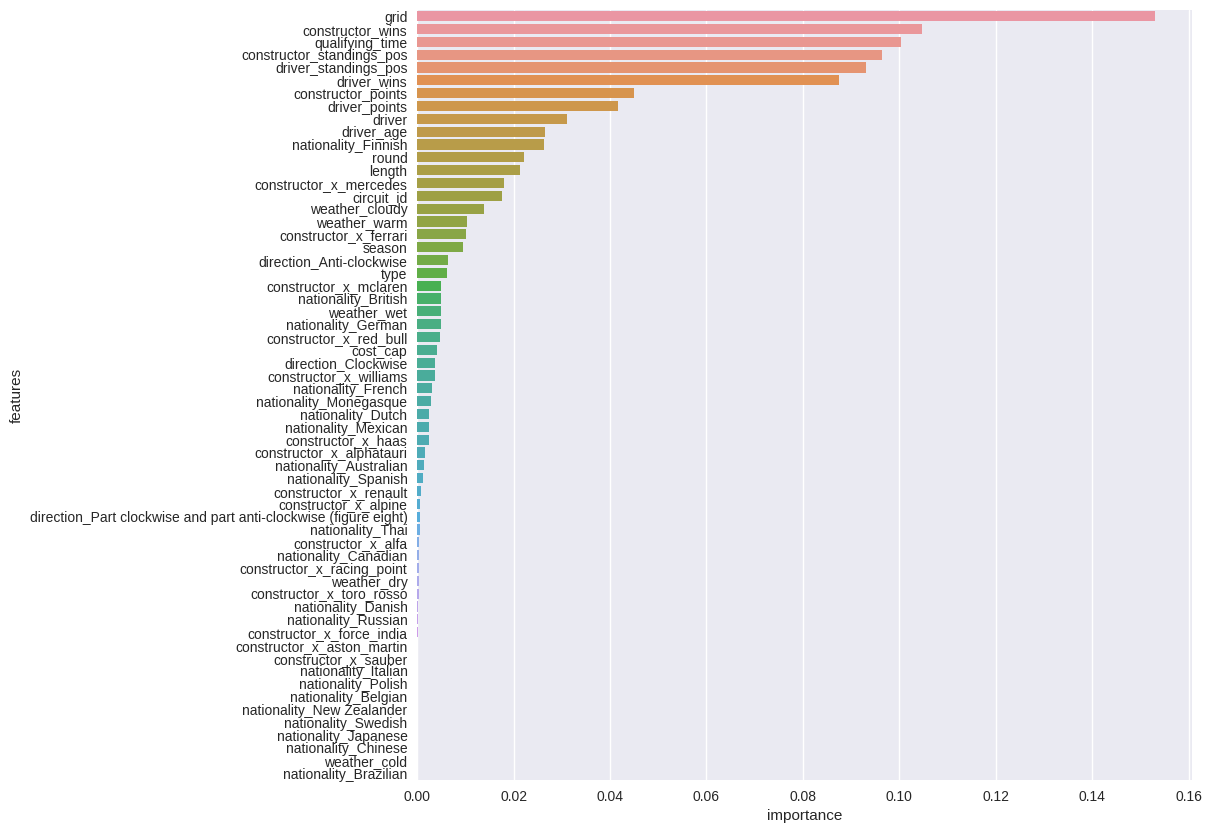

In [ ]:
plt.figure(figsize=(10,10))

sns.barplot(x="importance", y="features", data=fi)

# PCA with Cost Cap feauture

In [ ]:
pca = PCA(n_components=.80)
pca_transform = pca.fit_transform(scaled_data_train)
print(f'We need {len(pca.explained_variance_ratio_)} components to explain at least 80% of the variance')

# Note that explained_variance_ratio_ returns the amount of variance explained by each successive principal component


We need 27 components to explain at least 80% of the variance


In [ ]:
# let's do PCA with two components
pca_viz = PCA(n_components=2)
pca_viz_transform = pca_viz.fit_transform(scaled_data_train)

<ipython-input-23-d17818249d99>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("Paired")(np.linspace(0,1,len(classes_)))


Text(0.5, 1.0, 'PCA 1 Vs PCA 2')

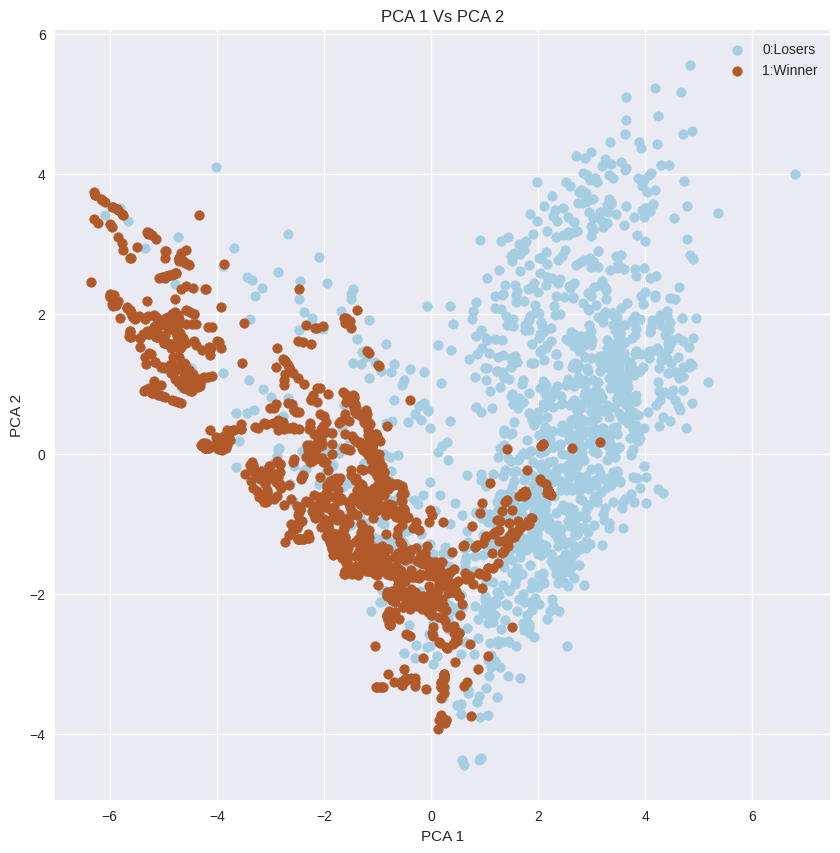

In [ ]:
#classes_ = Y_train.value_counts().index
classes_ = Y.value_counts().index

# let's get different colors to recognize the different classes
from matplotlib import cm
colors = cm.get_cmap("Paired")(np.linspace(0,1,len(classes_)))

plt.figure(figsize=(10,10))
for Y_class,color in zip(classes_, colors):
    # let's only plot the transformed data points for a given label
    plt.scatter(pca_viz_transform[Y==Y_class,0],
                pca_viz_transform[Y==Y_class,1],

                label=Y_class,
                color=color)
plt.legend( ['0:Losers', '1:Winner'])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA 1 Vs PCA 2')
#classes are not well separated, this is not a linear problem

# **Traditional Classification With Cost Cap**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import kernel_ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import sklearn.linear_model
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
#from sklearn.metrics import regression_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
X_train_pca=pca_transform
X_test_pca= pca.transform(scaled_data_test)


---------------------------------
SVC()
-----------------------------------
Accuracy on Test: 0.9056
Confusion matrix:  [[0.88495575 0.0619469 ]
 [0.03244838 0.02064897]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       321
           1       0.25      0.39      0.30        18

    accuracy                           0.91       339
   macro avg       0.61      0.66      0.63       339
weighted avg       0.93      0.91      0.92       339

Qualitative Insights:
Number of False Positives: 21
Number of False Negatives: 11
---------------------------------
KNeighborsClassifier(n_neighbors=3)
-----------------------------------
Accuracy on Test: 0.8791
Confusion matrix:  [[0.85840708 0.08849558]
 [0.03244838 0.02064897]]
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       321
           1       0.19      0.39      0.25        18

    accuracy                           0.88       339
 

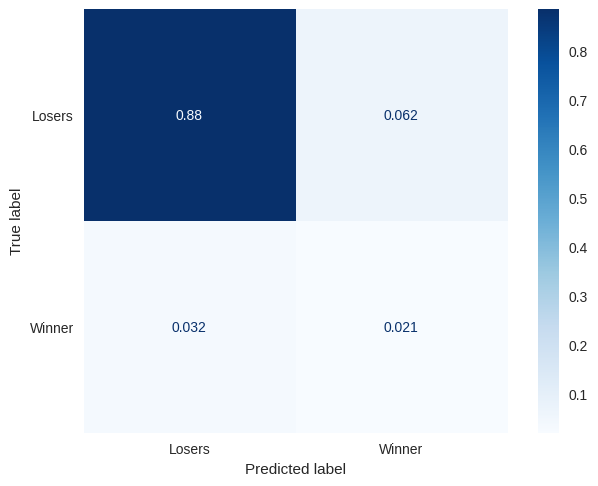

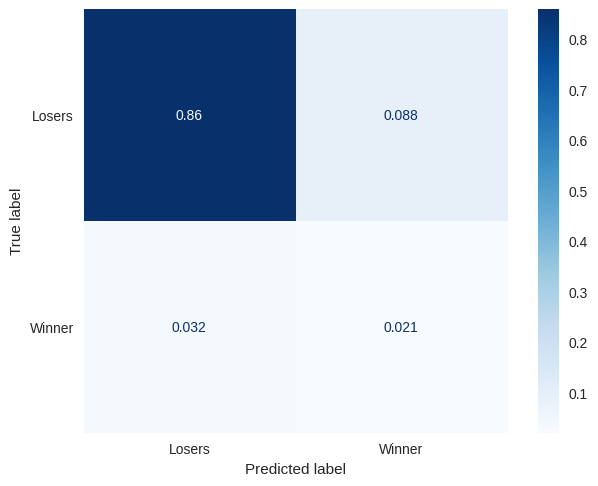

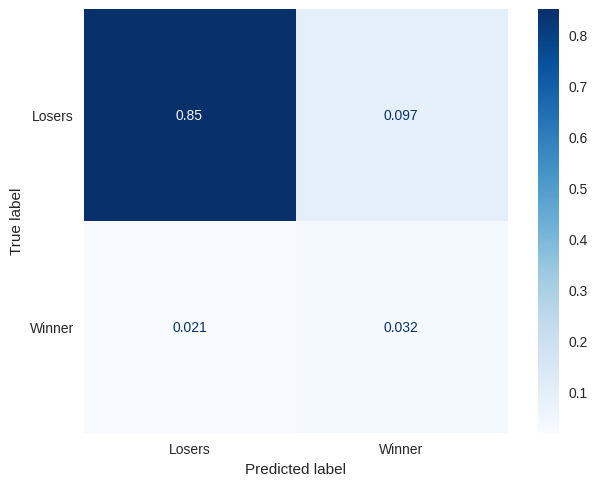

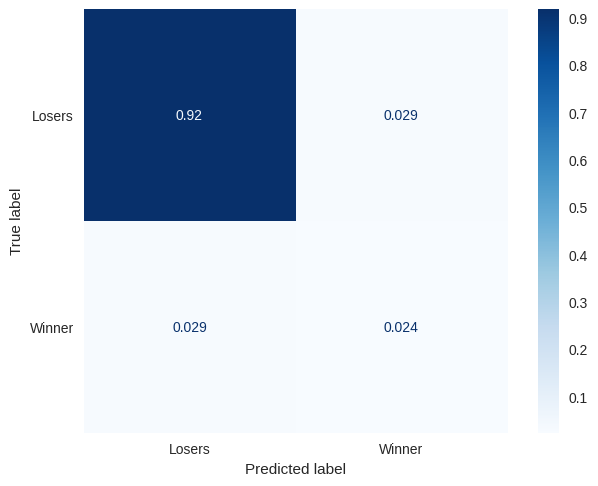

In [ ]:
clfs = []
clfs.append(SVC())
clfs.append(KNeighborsClassifier(n_neighbors=3))
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier()) #all classifiers on default hyperparameters

for classifier in clfs:
    model = classifier
    #Train
    model.fit(X_train_pca, Y)
    #Validate
    #Y_pred_valid= model.predict(X_valid)
    #Test
    Y_pred_test = model.predict(X_test_pca)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    # 3. evaluate
    #print('Accuracy on Validation: {:.4f}'.format(sklearn.metrics.accuracy_score(Y_valid, Y_pred_valid)))
    print('Accuracy on Test: {:.4f}'.format(sklearn.metrics.accuracy_score(Y_test, Y_pred_test)))
    # Confusion matrix
    confusion_mat = sklearn.metrics.confusion_matrix(Y_test,Y_pred_test, normalize='all')
    sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['Losers', 'Winner']).plot(cmap=plt.cm.Blues)
    plt.grid(False)
    print('Confusion matrix: ', confusion_mat)
    print(sklearn.metrics.classification_report(Y_test, Y_pred_test))
    # Qualitative Insights
    print("Qualitative Insights:")

    # Analyzing False Positives and False Negatives
    false_positives = X_test_pca[(Y_test == 0) & (Y_pred_test == 1)]
    false_negatives = X_test_pca[(Y_test == 1) & (Y_pred_test == 0)]

    print("Number of False Positives:", len(false_positives))
    print("Number of False Negatives:", len(false_negatives))


In [ ]:
# best performing model so lets see actuall prediction of driver and circuit predictions for 2022 and compare irl


# Neural Networks exploration With Cost Cap

### **BPNN**

<ipython-input-28-f8eea2f5349a>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ffnn_classifier = KerasClassifier(build_fn=build_ffnn, epochs=10, batch_size=32, verbose=0)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...........batch_size=16, epochs=8, hidden_units=38; total time=  15.0s
[CV] END ...........batch_size=16, epochs=8, hidden_units=38; total time=   6.4s
[CV] END ...........batch_size=16, epochs=8, hidden_units=38; total time=   5.5s
[CV] END ..........batch_size=24, epochs=15, hidden_units=17; total time=   4.5s
[CV] END ..........batch_size=24, epochs=15, hidden_units=17; total time=   6.2s
[CV] END ..........batch_size=24, epochs=15, hidden_units=17; total time=   6.2s
[CV] END ..........batch_size=16, epochs=14, hidden_units=28; total time=   5.9s
[CV] END ..........batch_size=16, epochs=14, hidden_units=28; total time=   6.3s
[CV] END ..........batch_size=16, epochs=14, hidden_units=28; total time=   5.2s
[CV] END ..........batch_size=20, epochs=15, hidden_units=33; total time=   5.5s
[CV] END ..........batch_size=20, epochs=15, hidden_units=33; total time=   6.3s
[CV] END ..........batch_size=20, epochs=15, hid

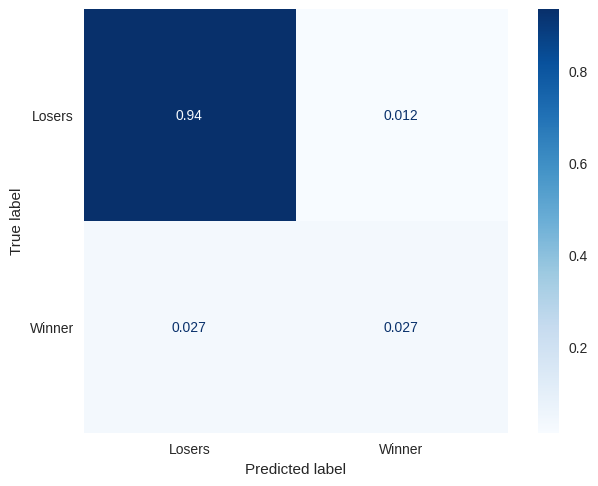

In [ ]:
#FNN w/ BPNN
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import make_classification
from keras.wrappers.scikit_learn import KerasClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score, classification_report


# Create a function to build the FFNN model
def build_ffnn(hidden_units=50):
    model = Sequential()
    model.add(Dense(units=hidden_units, activation='relu', input_shape=(X_train_pca.shape[1], )))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model in a scikit-learn estimator
ffnn_classifier = KerasClassifier(build_fn=build_ffnn, epochs=10, batch_size=32, verbose=0)

# Define the hyperparameters and their possible values for random grid search
param_dist = {
    'hidden_units': randint(10, 50),
    'epochs': randint(5, 20),
    'batch_size': randint(10, 30)
}

# Perform random grid search with cross-validation
random_search = RandomizedSearchCV(estimator=ffnn_classifier, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42)
random_search.fit(X_train_pca, Y)

# Get the best hyperparameters and the best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test_pca)
y_pred = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)

confusion_mat = sklearn.metrics.confusion_matrix(Y_test,y_pred, normalize='all')
print('Confusion matrix: ', confusion_mat)
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['Losers', 'Winner']).plot(cmap=plt.cm.Blues)
plt.grid(False)

report = classification_report(Y_test, y_pred)
print("Classification Report:\n", report)


### **LSTM**

<ipython-input-29-6a26d2188fcb>:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_classifier = KerasClassifier(build_fn=build_lstm, epochs=10, batch_size=32, verbose=0)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[CV] END ..........batch_size=54, epochs=8, hidden_units=122; total time=   4.5s


[CV] END ..........batch_size=54, epochs=8, hidden_units=122; total time=   4.4s


[CV] END ..........batch_size=54, epochs=8, hidden_units=122; total time=   7.1s


[CV] END .........batch_size=30, epochs=15, hidden_units=101; total time=   4.8s


[CV] END .........batch_size=30, epochs=15, hidden_units=101; total time=   8.8s


[CV] END .........batch_size=30, epochs=15, hidden_units=101; total time=  12.0s


[CV] END .........batch_size=36, epochs=11, hidden_units=112; total time=   6.9s


[CV] END .........batch_size=36, epochs=11, hidden_units=112; total time=   6.9s


[CV] END .........batch_size=36, epochs=11, hidden_units=112; total time=   5.2s


[CV] END .........batch_size=38, epochs=15, hidden_units=104; total time=   8.6s


[CV] END .........batch_size=38, epochs=15, hidden_units=104; total time=   6.9s


[CV] END .........batch_size=38, epochs=15, hidden_units=104; total time=  12.1s


[CV] END ..........batch_size=39, epochs=9, hidden_units=129; total time=   7.0s


[CV] END ..........batch_size=39, epochs=9, hidden_units=129; total time=   6.9s


[CV] END ..........batch_size=39, epochs=9, hidden_units=129; total time=   6.9s


[CV] END ..........batch_size=55, epochs=12, hidden_units=32; total time=   6.9s


[CV] END ..........batch_size=55, epochs=12, hidden_units=32; total time=   7.0s


[CV] END ..........batch_size=55, epochs=12, hidden_units=32; total time=   4.6s


[CV] END ...........batch_size=37, epochs=9, hidden_units=31; total time=   7.1s


[CV] END ...........batch_size=37, epochs=9, hidden_units=31; total time=   4.7s


[CV] END ...........batch_size=37, epochs=9, hidden_units=31; total time=   4.8s


[CV] END ..........batch_size=39, epochs=16, hidden_units=59; total time=  12.7s


[CV] END ..........batch_size=39, epochs=16, hidden_units=59; total time=   9.6s


[CV] END ..........batch_size=39, epochs=16, hidden_units=59; total time=   7.2s


[CV] END ...........batch_size=53, epochs=6, hidden_units=93; total time=   6.0s


[CV] END ...........batch_size=53, epochs=6, hidden_units=93; total time=   4.5s


[CV] END ...........batch_size=53, epochs=6, hidden_units=93; total time=   4.7s


[CV] END ..........batch_size=36, epochs=5, hidden_units=105; total time=   4.3s


[CV] END ..........batch_size=36, epochs=5, hidden_units=105; total time=   4.5s


[CV] END ..........batch_size=36, epochs=5, hidden_units=105; total time=   4.8s
11/11 [==============================] - 0s 2ms/step
Best Hyperparameters: {'batch_size': 39, 'epochs': 9, 'hidden_units': 129}
Accuracy: 0.9646017699115044
Confusion matrix:  [[0.9380531  0.00884956]
 [0.02654867 0.02654867]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       321
           1       0.75      0.50      0.60        18

    accuracy                           0.96       339
   macro avg       0.86      0.75      0.79       339
weighted avg       0.96      0.96      0.96       339



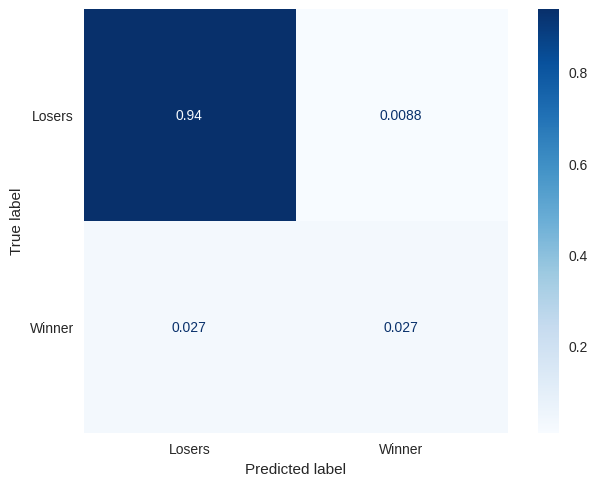

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.wrappers.scikit_learn import KerasClassifier

# Reshape the data for LSTM (samples, timesteps, features)
X_train_pca2 = X_train_pca.reshape(X_train_pca.shape[0], 1, X_train_pca.shape[1])
X_test_pca2 = X_test_pca.reshape(X_test_pca.shape[0], 1, X_test_pca.shape[1])

def build_lstm(hidden_units=50):
    model = Sequential()
    model.add(LSTM(units=hidden_units, activation='relu', input_shape=(X_train_pca2.shape[1], X_train_pca2.shape[2])))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model in a scikit-learn estimator
lstm_classifier = KerasClassifier(build_fn=build_lstm, epochs=10, batch_size=32, verbose=0)

# Define the hyperparameters and their possible values for random grid search
param_dist = {
    'hidden_units': randint(30, 150),
    'epochs': randint(5, 20),
    'batch_size': randint(16, 64)
}

# Perform random grid search with cross-validation
random_search = RandomizedSearchCV(estimator=lstm_classifier, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42)
random_search.fit(X_train_pca2, Y)

# Get the best hyperparameters and the best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test_pca2)
y_pred = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
# Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(Y_test,y_pred, normalize='all')
print('Confusion matrix: ', confusion_mat)
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['Losers', 'Winner']).plot(cmap=plt.cm.Blues)
plt.grid(False)
report = classification_report(Y_test, y_pred)
print("Classification Report:\n", report)

In [ ]:
#best perfoming NN

predicted_indices = np.where(y_pred == 1)[0]

# Retrieve circuit and driver names for the predicted target value of 1
predicted_circuits = test.loc[X_test.index[predicted_indices], 'circuit_id']
predicted_drivers = test.loc[X_test.index[predicted_indices], 'driver']

p_circuits= circuit_label_encoder.inverse_transform(predicted_circuits)
p_drivers= driver_label_encoder.inverse_transform(predicted_drivers)

# Print the results
print("Predicted Circuits with Target Value 1:")
print(p_circuits.tolist())

print("\nPredicted Drivers with Target Value 1:")
print(p_drivers.tolist())

Predicted Circuits with Target Value 1:
['bahrain', 'bahrain', 'catalunya', 'silverstone', 'ricard', 'spa', 'zandvoort', 'monza', 'suzuka', 'americas', 'rodriguez', 'yas_marina']

Predicted Drivers with Target Value 1:
['max_verstappen', 'hamilton', 'max_verstappen', 'max_verstappen', 'max_verstappen', 'max_verstappen', 'max_verstappen', 'max_verstappen', 'max_verstappen', 'max_verstappen', 'max_verstappen', 'max_verstappen']


### **RNN**

Fitting 3 folds for each of 10 candidates, totalling 30 fits


<ipython-input-31-c741a62f6936>:16: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  rnn_classifier = KerasClassifier(build_fn=build_rnn, epochs=10, batch_size=32, verbose=0)


[CV] END ..........batch_size=54, epochs=8, hidden_units=122; total time=   4.0s
[CV] END ..........batch_size=54, epochs=8, hidden_units=122; total time=   5.2s
[CV] END ..........batch_size=54, epochs=8, hidden_units=122; total time=   4.0s
[CV] END .........batch_size=30, epochs=15, hidden_units=101; total time=   4.4s
[CV] END .........batch_size=30, epochs=15, hidden_units=101; total time=   6.8s
[CV] END .........batch_size=30, epochs=15, hidden_units=101; total time=   5.4s
[CV] END .........batch_size=36, epochs=11, hidden_units=112; total time=   5.1s
[CV] END .........batch_size=36, epochs=11, hidden_units=112; total time=   4.6s
[CV] END .........batch_size=36, epochs=11, hidden_units=112; total time=   4.1s
[CV] END .........batch_size=38, epochs=15, hidden_units=104; total time=   6.5s
[CV] END .........batch_size=38, epochs=15, hidden_units=104; total time=   5.3s
[CV] END .........batch_size=38, epochs=15, hidden_units=104; total time=   6.9s
[CV] END ..........batch_siz

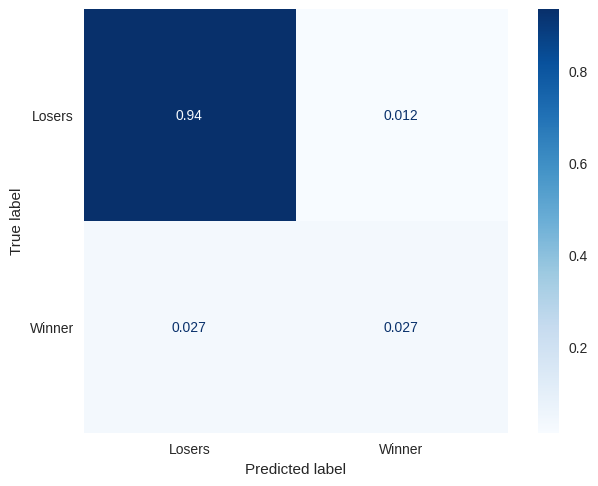

In [ ]:
from keras.layers import Dense, SimpleRNN

# Reshape the data for RNN (samples, timesteps, features)
X_train_rnn = X_train_pca.reshape(X_train_pca.shape[0], 1, X_train_pca.shape[1])
X_test_rnn = X_test_pca.reshape(X_test_pca.shape[0], 1, X_test_pca.shape[1])

# Create a function to build the RNN model
def build_rnn(hidden_units=50):
    model = Sequential()
    model.add(SimpleRNN(units=hidden_units, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model in a scikit-learn estimator
rnn_classifier = KerasClassifier(build_fn=build_rnn, epochs=10, batch_size=32, verbose=0)

# Define the hyperparameters and their possible values for random grid search
param_dist = {
    'hidden_units': randint(30, 150),
    'epochs': randint(5, 20),
    'batch_size': randint(16, 64)
}

# Perform random grid search with cross-validation
random_search = RandomizedSearchCV(estimator=rnn_classifier, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42)
random_search.fit(X_train_rnn, Y)

# Get the best hyperparameters and the best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test_rnn)
y_pred = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
# Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(Y_test,y_pred, normalize='all')
print('Confusion matrix: ', confusion_mat)
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['Losers', 'Winner']).plot(cmap=plt.cm.Blues)
plt.grid(False)

report = classification_report(Y_test, y_pred)
print("Classification Report:\n", report)

# **PCA Without Cost Cap**

In [ ]:
df = data_fr.copy()
df.podium = df.podium.map(lambda x: 1 if x == 1 else 0)

train = df[df.season <2022]
X_train = train.drop(['podium', 'cost_cap'], axis = 1)
Y_train = train.podium

test= df[df.season ==2022]
X_test=test.drop(['podium', 'cost_cap'], axis = 1)
Y_test= test.podium


In [ ]:
#ros = RandomOverSampler(random_state=0)  #dealing with data imbalances decided to undersample bc domt wanna assume new data so worked with i had, made the selection random
#X_raw, Y = ros.fit_resample(X_train, Y_train)
#print(sorted(Counter(Y).items()))

smote= SMOTE(random_state=0)
X_raw, Y = smote.fit_resample(X_train, Y_train)
print(sorted(Counter(Y).items()))


[(0, 1328), (1, 1328)]


In [ ]:
scaler = StandardScaler().set_output(transform="pandas")
#X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
scaled_data_train = scaler.fit_transform(X_raw)
scaled_data_test = scaler.transform(X_test)

In [ ]:
pca = PCA(n_components=.80)
pca_transform = pca.fit_transform(scaled_data_train)
print(f'We need {len(pca.explained_variance_ratio_)} components to explain at least 80% of the variance')

# Note that explained_variance_ratio_ returns the amount of variance explained by each successive principal component

We need 27 components to explain at least 80% of the variance


In [ ]:
# let's do PCA with two components
pca_viz = PCA(n_components=2)
pca_viz_transform = pca_viz.fit_transform(scaled_data_train)

<ipython-input-37-8131d2e8b365>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap("Paired")(np.linspace(0,1,len(classes_)))


Text(0.5, 1.0, 'PCA 1 Vs PCA 2')

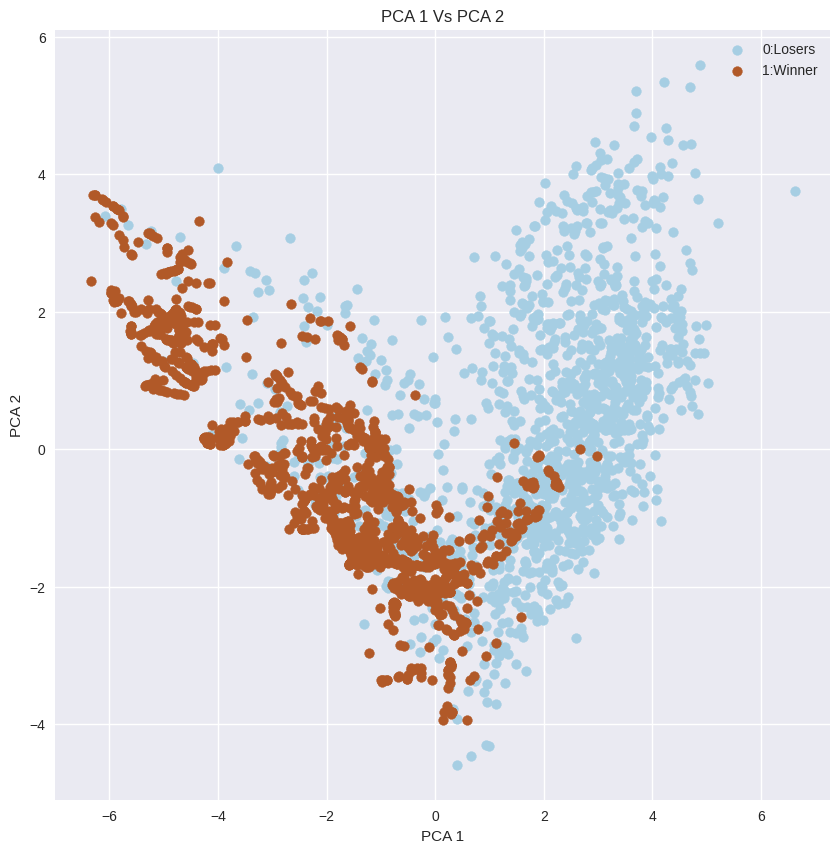

In [ ]:
#classes_ = Y_train.value_counts().index
classes_ = Y.value_counts().index

# let's get different colors to recognize the different classes
from matplotlib import cm
colors = cm.get_cmap("Paired")(np.linspace(0,1,len(classes_)))

plt.figure(figsize=(10,10))
for Y_class,color in zip(classes_, colors):
    # let's only plot the transformed data points for a given label
    plt.scatter(pca_viz_transform[Y==Y_class,0],
                pca_viz_transform[Y==Y_class,1],

                label=Y_class,
                color=color)
plt.legend( ['0:Losers', '1:Winner'])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA 1 Vs PCA 2')


# **Traditional Classification Without Cost Cap**

---------------------------------
SVC()
-----------------------------------
Accuracy on Test: 0.8997
Confusion matrix:  [[0.87905605 0.06784661]
 [0.03244838 0.02064897]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       321
           1       0.23      0.39      0.29        18

    accuracy                           0.90       339
   macro avg       0.60      0.66      0.62       339
weighted avg       0.93      0.90      0.91       339

---------------------------------
KNeighborsClassifier(n_neighbors=3)
-----------------------------------
Accuracy on Test: 0.8466
Confusion matrix:  [[0.8259587  0.12094395]
 [0.03244838 0.02064897]]
              precision    recall  f1-score   support

           0       0.96      0.87      0.92       321
           1       0.15      0.39      0.21        18

    accuracy                           0.85       339
   macro avg       0.55      0.63      0.56       339
weighted avg       0.92      

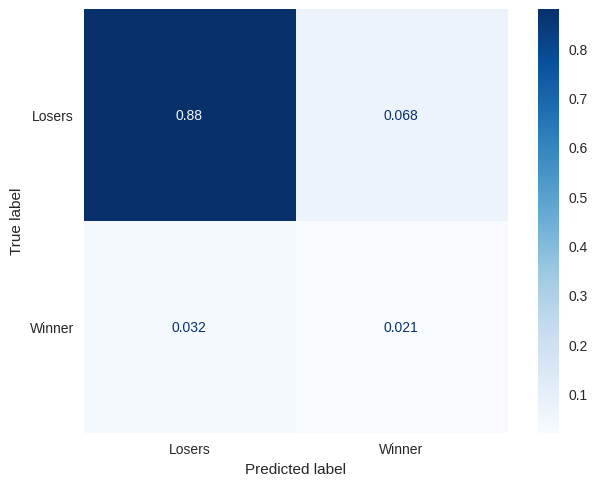

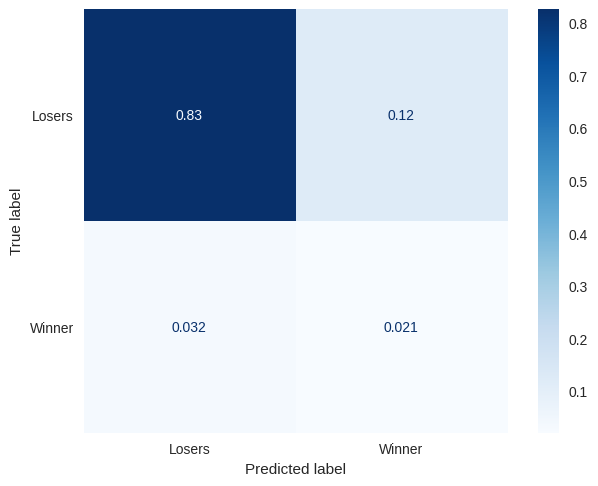

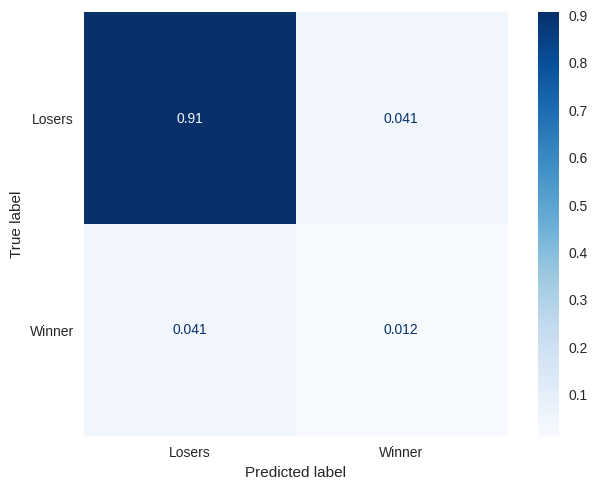

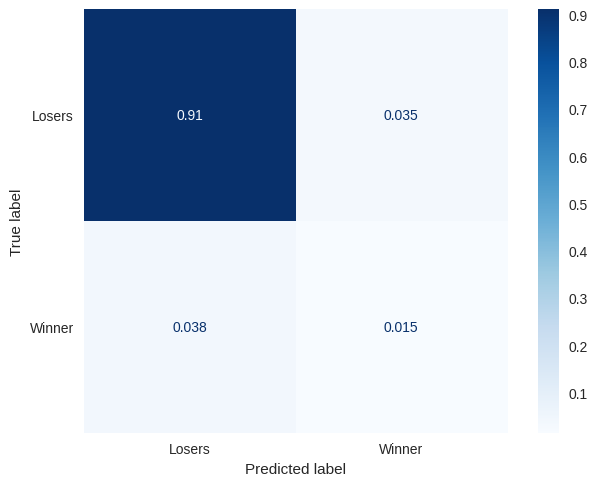

In [ ]:
X_train_pca=pca_transform
X_test_pca= pca.transform(scaled_data_test)

clfs = []
clfs.append(SVC())
clfs.append(KNeighborsClassifier(n_neighbors=3))
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier()) #all classifiers on default hyperparameters

for classifier in clfs:
    model = classifier
    #Train
    model.fit(X_train_pca, Y)
    #Validate
    #Y_pred_valid= model.predict(X_valid)
    #Test
    Y_pred_test = model.predict(X_test_pca)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    # 3. evaluate
    #print('Accuracy on Validation: {:.4f}'.format(sklearn.metrics.accuracy_score(Y_valid, Y_pred_valid)))
    print('Accuracy on Test: {:.4f}'.format(sklearn.metrics.accuracy_score(Y_test, Y_pred_test)))
    # Confusion matrix
    confusion_mat = sklearn.metrics.confusion_matrix(Y_test,Y_pred_test, normalize='all')
    print('Confusion matrix: ', confusion_mat)
    sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['Losers', 'Winner']).plot(cmap=plt.cm.Blues)
    plt.grid(False)
    print(sklearn.metrics.classification_report(Y_test, Y_pred_test))

# Neural Network Exploration without Cost Cap

###**BPNN**


<ipython-input-39-111e8d052ef9>:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ffnn_classifier = KerasClassifier(build_fn=build_ffnn, epochs=10, batch_size=32, verbose=0)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ...........batch_size=16, epochs=8, hidden_units=38; total time=   4.2s
[CV] END ...........batch_size=16, epochs=8, hidden_units=38; total time=   6.3s
[CV] END ...........batch_size=16, epochs=8, hidden_units=38; total time=   6.0s
[CV] END ..........batch_size=24, epochs=15, hidden_units=17; total time=   5.9s
[CV] END ..........batch_size=24, epochs=15, hidden_units=17; total time=   6.2s
[CV] END ..........batch_size=24, epochs=15, hidden_units=17; total time=   4.8s
[CV] END ..........batch_size=16, epochs=14, hidden_units=28; total time=   5.9s
[CV] END ..........batch_size=16, epochs=14, hidden_units=28; total time=   5.4s
[CV] END ..........batch_size=16, epochs=14, hidden_units=28; total time=   6.6s
[CV] END ..........batch_size=20, epochs=15, hidden_units=33; total time=   6.0s
[CV] END ..........batch_size=20, epochs=15, hidden_units=33; total time=   5.9s
[CV] END ..........batch_size=20, epochs=15, hid

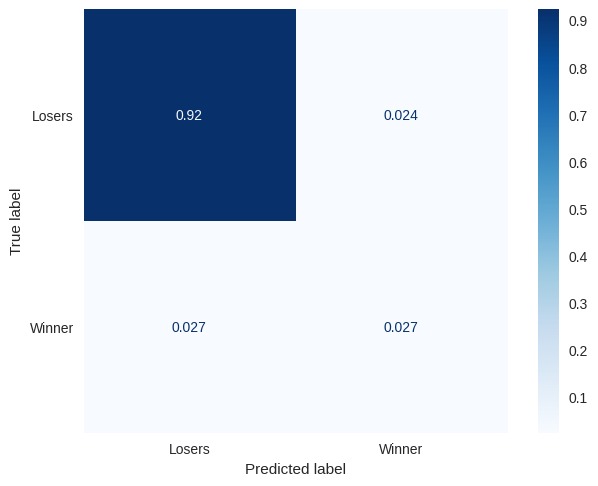

In [ ]:
# Create a function to build the BPNN model
def build_ffnn(hidden_units=50):
    model = Sequential()
    model.add(Dense(units=hidden_units, activation='relu', input_shape=(X_train_pca.shape[1], )))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model in a scikit-learn estimator
ffnn_classifier = KerasClassifier(build_fn=build_ffnn, epochs=10, batch_size=32, verbose=0)

# Define the hyperparameters and their possible values for random grid search
param_dist = {
    'hidden_units': randint(10, 50),
    'epochs': randint(5, 20),
    'batch_size': randint(10, 30)
}

# Perform random grid search with cross-validation
random_search = RandomizedSearchCV(estimator=ffnn_classifier, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42)
random_search.fit(X_train_pca, Y)

# Get the best hyperparameters and the best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test_pca)
y_pred = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)

# Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(Y_test,y_pred, normalize='all')
print('Confusion matrix: ', confusion_mat)
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['Losers', 'Winner']).plot(cmap=plt.cm.Blues)
plt.grid(False)

report = classification_report(Y_test, y_pred)
print("Classification Report:\n", report)

### **LSTM**

<ipython-input-40-f660d459d96d>:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm_classifier = KerasClassifier(build_fn=build_lstm, epochs=10, batch_size=32, verbose=0)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[CV] END ..........batch_size=54, epochs=8, hidden_units=122; total time=   4.7s


[CV] END ..........batch_size=54, epochs=8, hidden_units=122; total time=   7.8s


[CV] END ..........batch_size=54, epochs=8, hidden_units=122; total time=   3.9s


[CV] END .........batch_size=30, epochs=15, hidden_units=101; total time=   6.7s


[CV] END .........batch_size=30, epochs=15, hidden_units=101; total time=   7.3s


[CV] END .........batch_size=30, epochs=15, hidden_units=101; total time=   8.7s


[CV] END .........batch_size=36, epochs=11, hidden_units=112; total time=   5.4s


[CV] END .........batch_size=36, epochs=11, hidden_units=112; total time=   8.4s


[CV] END .........batch_size=36, epochs=11, hidden_units=112; total time=   7.3s


[CV] END .........batch_size=38, epochs=15, hidden_units=104; total time=   7.7s


[CV] END .........batch_size=38, epochs=15, hidden_units=104; total time=   6.9s


[CV] END .........batch_size=38, epochs=15, hidden_units=104; total time=   7.5s


[CV] END ..........batch_size=39, epochs=9, hidden_units=129; total time=   4.7s


[CV] END ..........batch_size=39, epochs=9, hidden_units=129; total time=   7.6s


[CV] END ..........batch_size=39, epochs=9, hidden_units=129; total time=   4.5s


[CV] END ..........batch_size=55, epochs=12, hidden_units=32; total time=   8.6s


[CV] END ..........batch_size=55, epochs=12, hidden_units=32; total time=   7.3s


[CV] END ..........batch_size=55, epochs=12, hidden_units=32; total time=   7.7s


[CV] END ...........batch_size=37, epochs=9, hidden_units=31; total time=   7.2s


[CV] END ...........batch_size=37, epochs=9, hidden_units=31; total time=   4.9s


[CV] END ...........batch_size=37, epochs=9, hidden_units=31; total time=   7.1s


[CV] END ..........batch_size=39, epochs=16, hidden_units=59; total time=   6.7s


[CV] END ..........batch_size=39, epochs=16, hidden_units=59; total time=   6.9s


[CV] END ..........batch_size=39, epochs=16, hidden_units=59; total time=   7.9s


[CV] END ...........batch_size=53, epochs=6, hidden_units=93; total time=   4.8s


[CV] END ...........batch_size=53, epochs=6, hidden_units=93; total time=   4.5s


[CV] END ...........batch_size=53, epochs=6, hidden_units=93; total time=   4.5s


[CV] END ..........batch_size=36, epochs=5, hidden_units=105; total time=   4.6s


[CV] END ..........batch_size=36, epochs=5, hidden_units=105; total time=   5.0s


[CV] END ..........batch_size=36, epochs=5, hidden_units=105; total time=   4.4s
11/11 [==============================] - 0s 3ms/step
Best Hyperparameters: {'batch_size': 37, 'epochs': 9, 'hidden_units': 31}
Accuracy: 0.9557522123893806
Confusion matrix:  [[0.92920354 0.01769912]
 [0.02654867 0.02654867]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       321
           1       0.60      0.50      0.55        18

    accuracy                           0.96       339
   macro avg       0.79      0.74      0.76       339
weighted avg       0.95      0.96      0.95       339



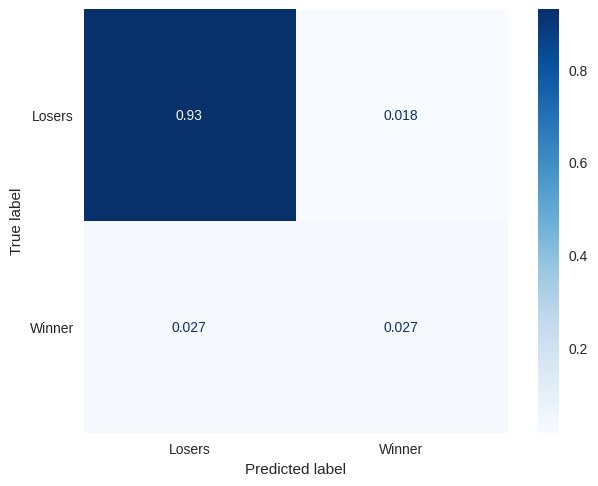

In [ ]:
# Reshape the data for LSTM (samples, timesteps, features)
X_train_pca2 = X_train_pca.reshape(X_train_pca.shape[0], 1, X_train_pca.shape[1])
X_test_pca2 = X_test_pca.reshape(X_test_pca.shape[0], 1, X_test_pca.shape[1])

def build_lstm(hidden_units=50):
    model = Sequential()
    model.add(LSTM(units=hidden_units, activation='relu', input_shape=(X_train_pca2.shape[1], X_train_pca2.shape[2])))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model in a scikit-learn estimator
lstm_classifier = KerasClassifier(build_fn=build_lstm, epochs=10, batch_size=32, verbose=0)

# Define the hyperparameters and their possible values for random grid search
param_dist = {
    'hidden_units': randint(30, 150),
    'epochs': randint(5, 20),
    'batch_size': randint(16, 64)
}

# Perform random grid search with cross-validation
random_search = RandomizedSearchCV(estimator=lstm_classifier, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42)
random_search.fit(X_train_pca2, Y)

# Get the best hyperparameters and the best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test_pca2)
y_pred = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
# Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(Y_test,y_pred, normalize='all')
print('Confusion matrix: ', confusion_mat)
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['Losers', 'Winner']).plot(cmap=plt.cm.Blues)
plt.grid(False)

report = classification_report(Y_test, y_pred)
print("Classification Report:\n", report)

In [ ]:
#best perfoming NN

predicted_indices = np.where(y_pred == 1)[0]

# Retrieve circuit and driver names for the predicted target value of 1
predicted_circuits = test.loc[X_test.index[predicted_indices], 'circuit_id']
predicted_drivers = test.loc[X_test.index[predicted_indices], 'driver']

p_circuits= circuit_label_encoder.inverse_transform(predicted_circuits)
p_drivers= driver_label_encoder.inverse_transform(predicted_drivers)

# Print the results
print("Predicted Circuits with Target Value 1:")
print(p_circuits.tolist())

print("\nPredicted Drivers with Target Value 1:")
print(p_drivers.tolist())

Predicted Circuits with Target Value 1:
['bahrain', 'bahrain', 'bahrain', 'catalunya', 'catalunya', 'catalunya', 'silverstone', 'ricard', 'spa', 'zandvoort', 'monza', 'suzuka', 'americas', 'rodriguez', 'yas_marina']

Predicted Drivers with Target Value 1:
['max_verstappen', 'hamilton', 'russell', 'max_verstappen', 'russell', 'hamilton', 'max_verstappen', 'max_verstappen', 'max_verstappen', 'max_verstappen', 'max_verstappen', 'max_verstappen', 'max_verstappen', 'max_verstappen', 'max_verstappen']


### **RNN**

Fitting 3 folds for each of 10 candidates, totalling 30 fits


<ipython-input-42-1ce748cff244>:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  rnn_classifier = KerasClassifier(build_fn=build_rnn, epochs=10, batch_size=32, verbose=0)


[CV] END ..........batch_size=54, epochs=8, hidden_units=122; total time=   4.4s
[CV] END ..........batch_size=54, epochs=8, hidden_units=122; total time=   4.6s
[CV] END ..........batch_size=54, epochs=8, hidden_units=122; total time=   4.0s
[CV] END .........batch_size=30, epochs=15, hidden_units=101; total time=   4.2s
[CV] END .........batch_size=30, epochs=15, hidden_units=101; total time=  11.9s
[CV] END .........batch_size=30, epochs=15, hidden_units=101; total time=   6.8s
[CV] END .........batch_size=36, epochs=11, hidden_units=112; total time=   4.0s
[CV] END .........batch_size=36, epochs=11, hidden_units=112; total time=   6.6s
[CV] END .........batch_size=36, epochs=11, hidden_units=112; total time=   4.6s
[CV] END .........batch_size=38, epochs=15, hidden_units=104; total time=   5.4s
[CV] END .........batch_size=38, epochs=15, hidden_units=104; total time=   6.8s
[CV] END .........batch_size=38, epochs=15, hidden_units=104; total time=   4.7s
[CV] END ..........batch_siz

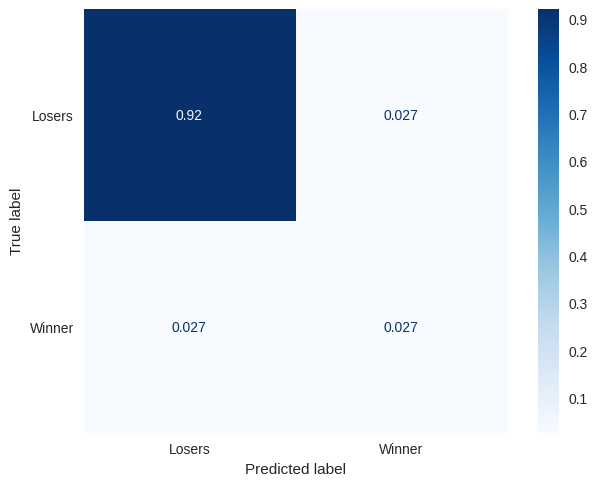

In [ ]:
# Reshape the data for RNN (samples, timesteps, features)
X_train_rnn = X_train_pca.reshape(X_train_pca.shape[0], 1, X_train_pca.shape[1])
X_test_rnn = X_test_pca.reshape(X_test_pca.shape[0], 1, X_test_pca.shape[1])

# Create a function to build the RNN model
def build_rnn(hidden_units=50):
    model = Sequential()
    model.add(SimpleRNN(units=hidden_units, activation='relu', input_shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model in a scikit-learn estimator
rnn_classifier = KerasClassifier(build_fn=build_rnn, epochs=10, batch_size=32, verbose=0)

# Define the hyperparameters and their possible values for random grid search
param_dist = {
    'hidden_units': randint(30, 150),
    'epochs': randint(5, 20),
    'batch_size': randint(16, 64)
}

# Perform random grid search with cross-validation
random_search = RandomizedSearchCV(estimator=rnn_classifier, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42)
random_search.fit(X_train_rnn, Y)

# Get the best hyperparameters and the best model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test_rnn)
y_pred = (y_pred > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
# Confusion matrix
confusion_mat = sklearn.metrics.confusion_matrix(Y_test,y_pred, normalize='all')
print('Confusion matrix: ', confusion_mat)
sklearn.metrics.ConfusionMatrixDisplay(confusion_mat, display_labels=['Losers', 'Winner']).plot(cmap=plt.cm.Blues)
plt.grid(False)

report = classification_report(Y_test, y_pred)
print("Classification Report:\n", report)

# Visualisation of Winners

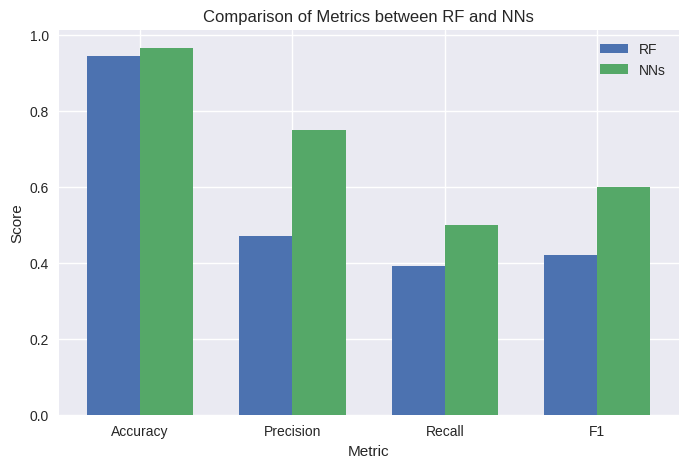

In [ ]:
# Create two groups of data
rf = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'Score': [0.944,0.47, 0.39, 0.42]
}

NNs = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
    'Score': [0.9646,0.75, 0.50, 0.60]
}

# Create DataFrames for each group
df_group1 = pd.DataFrame(rf)
df_group2 = pd.DataFrame(NNs)

# Create a comparison bar chart
fig, ax = plt.subplots(figsize=(8, 5))

# Bar positions
bar_width = 0.35
bar_positions_group1 = range(len(df_group1))
bar_positions_group2 = [pos + bar_width for pos in bar_positions_group1]

# Plot bars for each group
ax.bar(bar_positions_group1, df_group1['Score'], bar_width, label='RF')
ax.bar(bar_positions_group2, df_group2['Score'], bar_width, label='NNs')

# Set x-axis ticks and labels
ax.set_xticks([pos + bar_width / 2 for pos in bar_positions_group1])
ax.set_xticklabels(df_group1['Metric'])

# Set labels and title
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics between RF and NNs')
ax.legend()

plt.show()

In [ ]:
import sys
print(sys.version)

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
